# This notebooks shows using alternative state space searches during in silico evolution
#### It uses the synthetic sequences file generated via FLY_KC_EFS notebook.
#### It consists of:
* Choosing top 20 best mutations instead of only top 1 during in silico evolution
* Investigating different evolution paths
* Choosing 5 random mutations instead following the model's guidance
#### Intermediate files are saved to ./data/mutation_combination folder
#### Figures are saved to ./figures/mutation_combination

### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading DeepFlyBrain data to be used for the initialization of shap.DeepExplainer


In [2]:
print('Loading data...')
f = open('./data/deepflybrain/DeepFlyBrain_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

Loading data...


### Loading the model and initializing shap.DeepExplainer


In [3]:
print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "DeepFlyBrain"
model_json_file = "models/deepflybrain/model.json"
model_hdf5_file = "models/deepflybrain/model_epoch_83.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), nonAugmented_data_dict["train_data"][rn])

Loading model...


In [4]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### Loading the generated sequences via in silico evolution

In [5]:
import pickle
f = open("data/deepflybrain/FLY_KC_EFS_6000_withmut.pkl", "rb")
evolved_seq_6000_dict = pickle.load(f)
f.close()

### Here in every mutational step, the top 20 best mutations are chosen instead of only top 1 during in silico evolution
### This is run for 5 mutational steps

In [6]:
# def select_20(mutation_dict):
#     new_mutation_dict = {}
#     for mut_ in mutation_dict.keys():
#         mutagenesis_X = utils.create_saturation_mutagenesis_x(mutation_dict[mut_])
#         prediction_mutagenesis_X = model_dict["DeepFlyBrain"].predict(mutagenesis_X["X"])
#         original_prediction = model_dict["DeepFlyBrain"].predict(mutation_dict[mut_])
#         next_20 = mutagenesis_X["ids"][np.argsort((prediction_mutagenesis_X[:,34]-original_prediction[:,34]))[::-1][:20]]
#         for next_one in next_20:
#             new_start_x = np.copy(mutation_dict[mut_])
#             new_start_x[0][int(next_one.split("_")[0]),:] = np.array(nuc_to_onehot[next_one.split("_")[1]], dtype='int8')
#             new_mutation_dict[mut_+"-"+next_one] = new_start_x
#     return new_mutation_dict

# stepwise_mutation_dict = {}
# id_ = 35
# start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])
# mutation_dict = {}
# mutation_dict["0"] = start_x
# stepwise_mutation_dict[0] = mutation_dict
# for i in range(1,6):
#     stepwise_mutation_dict[i] = select_20(stepwise_mutation_dict[i-1])

# import pickle
# f = open("data/mutation_combination/stepwise_mutation_dict.pkl", "wb")
# pickle.dump(stepwise_mutation_dict, f ,protocol=4)
# f.close()

# stepwise_mutation_dict_pred = {}
# for key in stepwise_mutation_dict:
#     stepwise_mutation_dict_pred[key] = model_dict["DeepFlyBrain"].predict(np.array(list(stepwise_mutation_dict[key].values()))[:,0,:,:])

# import pickle
# f = open("data/mutation_combination/stepwise_mutation_dict_pred.pkl", "wb")
# pickle.dump(stepwise_mutation_dict_pred, f ,protocol=4)
# f.close()

In [7]:
f = open("data/mutation_combination/stepwise_mutation_dict.pkl", "rb")
stepwise_mutation_dict = pickle.load(f)
f.close()

f = open("data/mutation_combination/stepwise_mutation_dict_pred.pkl", "rb")
stepwise_mutation_dict_pred = pickle.load(f)
f.close()

In [8]:
for i in stepwise_mutation_dict:
    print(len(stepwise_mutation_dict[i]))

1
20
400
8000
160000
3200000


### Plotting prediction score distribution of the generated sequences after 5 steps

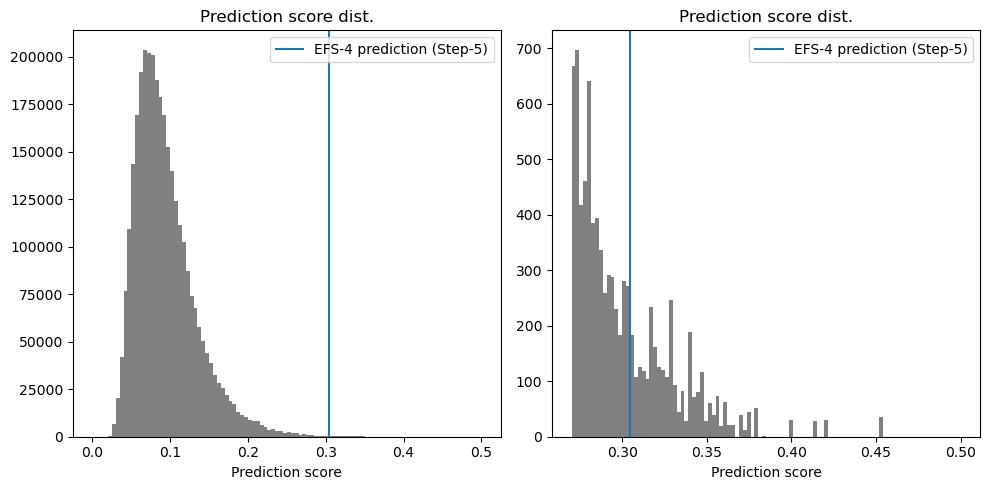

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
step = 5
plt.hist(stepwise_mutation_dict_pred[step][:,34],bins=100,range=[0,0.5],color='gray')
for i in evolved_seq_6000_dict['mut_pred'][[35],step,34]:
    plt.axvline(x=i,label="EFS-4 prediction (Step-5)")
plt.legend()
plt.title("Prediction score dist.")
plt.xlabel("Prediction score")

ax = fig.add_subplot(1,2,2)
step = 5
plt.hist(stepwise_mutation_dict_pred[step][:,34],bins=100,range=[0.27,0.5],color='gray')
plt.axvline(evolved_seq_6000_dict['mut_pred'][[35],step,34],label="EFS-4 prediction (Step-5)")
plt.legend()
plt.title("Prediction score dist.")
plt.xlabel("Prediction score")

fig.tight_layout()
plt.savefig("figures/mutation_combination/EFS4_5Steps_20mut_pred_distribution.pdf",transparent=True)

### Number of mutational paths that result higher prediction score than the greedy algorithm path

In [10]:
sum(stepwise_mutation_dict_pred[5][:,34]>evolved_seq_6000_dict["mut_pred"][35,5,34])

2941

### Top 10 best mutational path

In [11]:
np.argsort(stepwise_mutation_dict_pred[5][:,34])[::-1][:10]

array([ 904880, 3189600,  907600,  802800, 3184400,  904040,  898000,
        907620,  802880, 3184020])

In [12]:
np.array(list(stepwise_mutation_dict[5].keys()))[[904880, 3189600,  907600,  802800, 3184400,  904040,  898000, 907620, 802880, 3184020]]

array(['0-254_T-250_A-221_C-230_C-242_C',
       '0-250_A-221_C-230_C-242_C-254_T',
       '0-254_T-250_A-230_C-242_C-221_C',
       '0-254_T-221_C-250_A-242_C-230_C',
       '0-250_A-221_C-254_T-242_C-230_C',
       '0-254_T-250_A-242_C-230_C-221_C',
       '0-254_T-230_C-250_A-242_C-221_C',
       '0-254_T-250_A-230_C-221_C-242_C',
       '0-254_T-221_C-250_A-230_C-242_C',
       '0-250_A-221_C-242_C-230_C-254_T'], dtype='<U31')

In [13]:
print(*evolved_seq_6000_dict['mut_loc'][35][:5])

150_G 221_C 253_T 234_A 231_G


### Plotting prediction scores at different mutational steps for one of the path that results higher prediction score compared to greedy search

In [14]:
print(np.argwhere(np.array(list(stepwise_mutation_dict[0].keys()))=='0'))
print(np.argwhere(np.array(list(stepwise_mutation_dict[1].keys()))=='0-254_T'))
print(np.argwhere(np.array(list(stepwise_mutation_dict[2].keys()))=='0-254_T-250_A'))
print(np.argwhere(np.array(list(stepwise_mutation_dict[3].keys()))=='0-254_T-250_A-221_C'))
print(np.argwhere(np.array(list(stepwise_mutation_dict[4].keys()))=='0-254_T-250_A-221_C-230_C'))
print(np.argwhere(np.array(list(stepwise_mutation_dict[5].keys()))=='0-254_T-250_A-221_C-230_C-242_C'))

[[0]]
[[5]]
[[113]]
[[2262]]
[[45244]]
[[904880]]


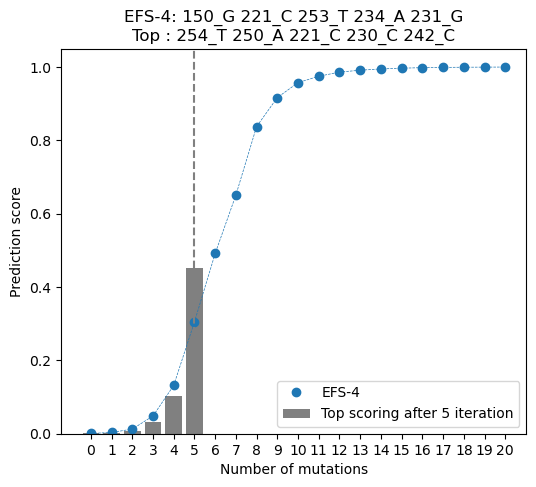

In [15]:
plt.figure(figsize=(6,5))
topic=34
ids__ = [35]
for k,i in enumerate(ids__):
    _ = plt.plot(evolved_seq_6000_dict["mut_pred"][i,:21,topic].T,label="EFS-4",linestyle="",marker="o",color="C"+str(k))
plt.legend()
for k,i in enumerate(ids__):
    _ = plt.plot(evolved_seq_6000_dict["mut_pred"][i,:21,topic].T,linestyle="--",linewidth=0.5,color="C"+str(k))
_ = plt.xticks(range(21),list(range(21)))
plt.axvline(x=5,linestyle="--",color="gray")
plt.xlabel("Number of mutations")
plt.ylabel("Prediction score")
plt.title("EFS-4: 150_G 221_C 253_T 234_A 231_G\nTop : 254_T 250_A 221_C 230_C 242_C")
plt.bar(0,stepwise_mutation_dict_pred[0][0,34],color="gray",label='Top scoring after 5 iteration')
plt.bar(1,stepwise_mutation_dict_pred[1][5,34],color="gray")
plt.bar(2,stepwise_mutation_dict_pred[2][113,34],color="gray")
plt.bar(3,stepwise_mutation_dict_pred[3][2262,34],color="gray")
plt.bar(4,stepwise_mutation_dict_pred[4][45244,34],color="gray")
plt.bar(5,stepwise_mutation_dict_pred[5][904880,34],color="gray")
plt.legend()
plt.savefig("figures/mutation_combination/EFS4_5Steps_20mut_top_example.pdf",transparent=True)

### Plotting nucleotide contribution scores at different mutational steps for one of the path that results higher prediction score compared to greedy search

0,1,2,3,4,

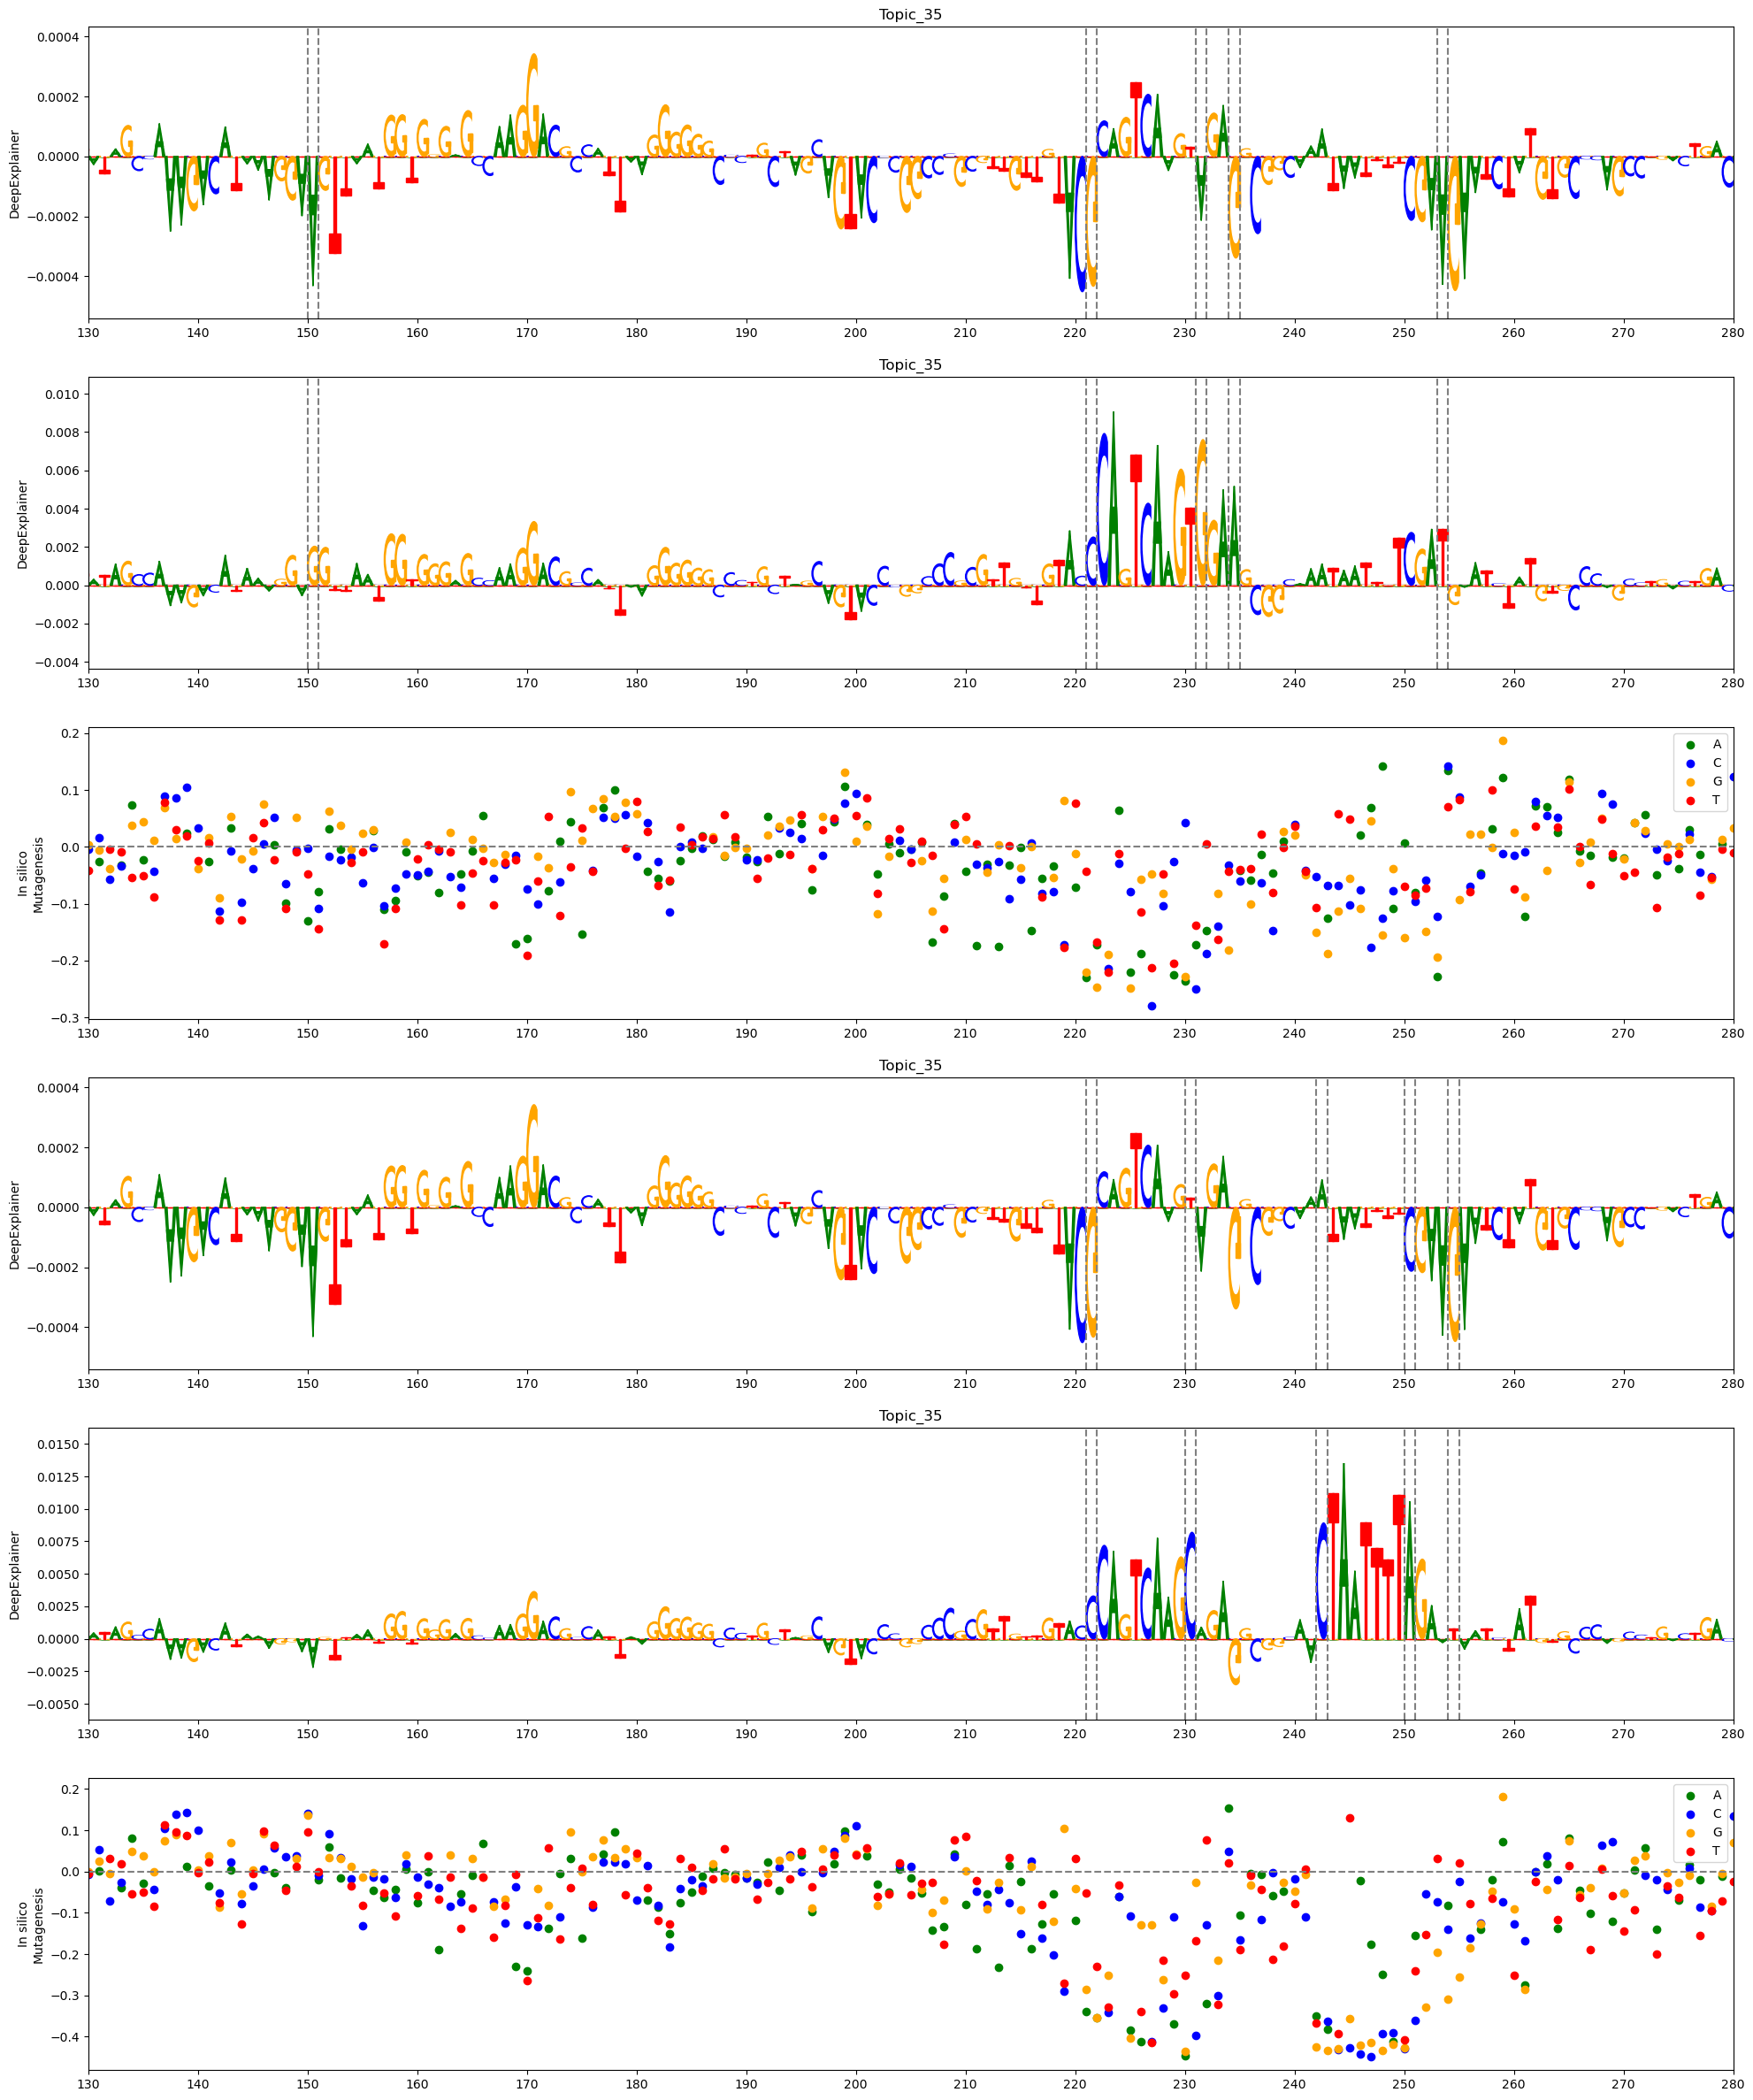

In [16]:
#[1,21,32,35,59,61,91]
id_ = 35
st = 130
end = 280

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}
start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])

ntrack = 6
fig = plt.figure(figsize=(24,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:5]):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
ax_1 = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:5]):
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])  
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 35)
start_x = np.copy(stepwise_mutation_dict[5]['0-254_T-250_A-221_C-230_C-242_C'])
ax4 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=5, seq_onehot=start_x, class_no = 35)
ax_2 = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=6, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(["254_T","250_A","221_C","230_C","242_C"]):
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax4.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

for ax in [ax1,ax2,ax3,ax4,ax_1,ax_2]:
    ax.set_xlim([st,end])

plt.savefig("figures/mutation_combination/EFS4_5Steps_20mut_top_example_deepexplainer.pdf",transparent=True)

### Here 5 random mutation is chosen 5 instead following the model's guidance

In [11]:
import random
id_ = 35
start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])
possible_mutations = utils.create_saturation_mutagenesis_x(start_x)

five_mut_dict = {}
five_mut_dict['ids'] = []
five_mut_dict['seq'] = []
for i in range(3200000):
    selected_muts = random.sample(possible_mutations['ids'],5)
    new_start_x = np.copy(start_x)
    for next_one in selected_muts:
        new_start_x[0][int(next_one.split("_")[0]),:] = np.array(nuc_to_onehot[next_one.split("_")[1]], dtype='int8')
    five_mut_dict['ids'].append('__'.join(selected_muts))
    five_mut_dict['seq'].append(new_start_x)
five_mut_dict['ids'] = np.array(five_mut_dict['ids'])
five_mut_dict['seq'] = np.array(five_mut_dict['seq'])
five_mut_dict['pred'] = model_dict["DeepFlyBrain"].predict(five_mut_dict['seq'][:,0,:,:])

import pickle
f = open("data/mutation_combination/five_mut_dict.pkl", "wb")
pickle.dump(five_mut_dict, f ,protocol=4)
f.close()

In [12]:
f = open("data/mutation_combination/five_mut_dict.pkl", "rb")
five_mut_dict = pickle.load(f)
f.close()

### Plotting the prediction score distribution after applying 5 random mutations to random sequences

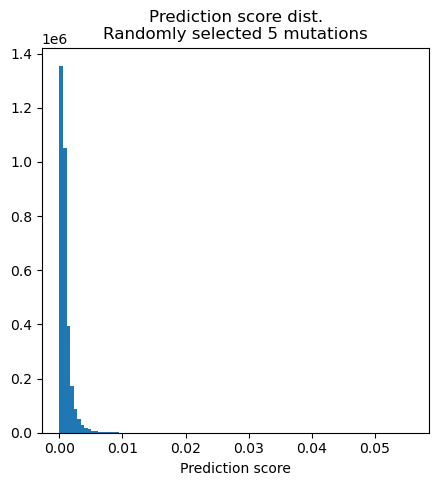

In [13]:
fig = plt.figure(figsize=(5,5))
_ = plt.hist(five_mut_dict['pred'][:,34],100)
plt.title("Prediction score dist.\nRandomly selected 5 mutations")
plt.xlabel("Prediction score")
plt.savefig("figures/mutation_combination/EFS4_5Steps_random5mut_distribution.pdf",transparent=True)

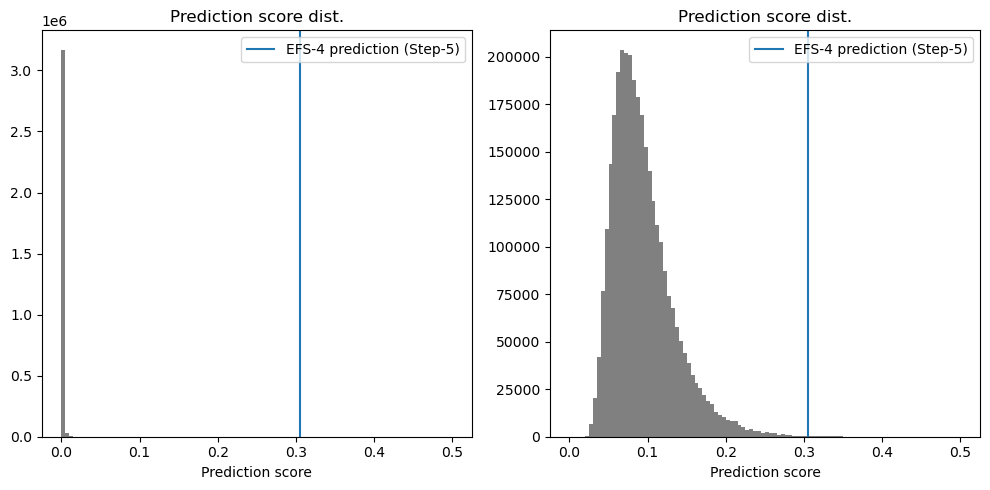

In [14]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,2)
step = 5
plt.hist(stepwise_mutation_dict_pred[step][:,34],bins=100,range=[0,0.5],color='gray')
for i in evolved_seq_6000_dict['mut_pred'][[35],step,34]:
    plt.axvline(x=i,label="EFS-4 prediction (Step-5)")
plt.legend()
plt.title("Prediction score dist.")
plt.xlabel("Prediction score")

ax = fig.add_subplot(1,2,1)
plt.hist(five_mut_dict['pred'][:,34],bins=100,range=[0,0.5],color='gray')
plt.axvline(evolved_seq_6000_dict['mut_pred'][[35],step,34],label="EFS-4 prediction (Step-5)")
plt.legend()
plt.title("Prediction score dist.")
plt.xlabel("Prediction score")

fig.tight_layout()
plt.savefig("figures/mutation_combination/EFS4_5Steps_random5mut_vs_20best_distribution.pdf",transparent=True)